Tangan Kiri

Processing images in folder: kk\001
Processing image: kk\001\019_F_R_0.JPG


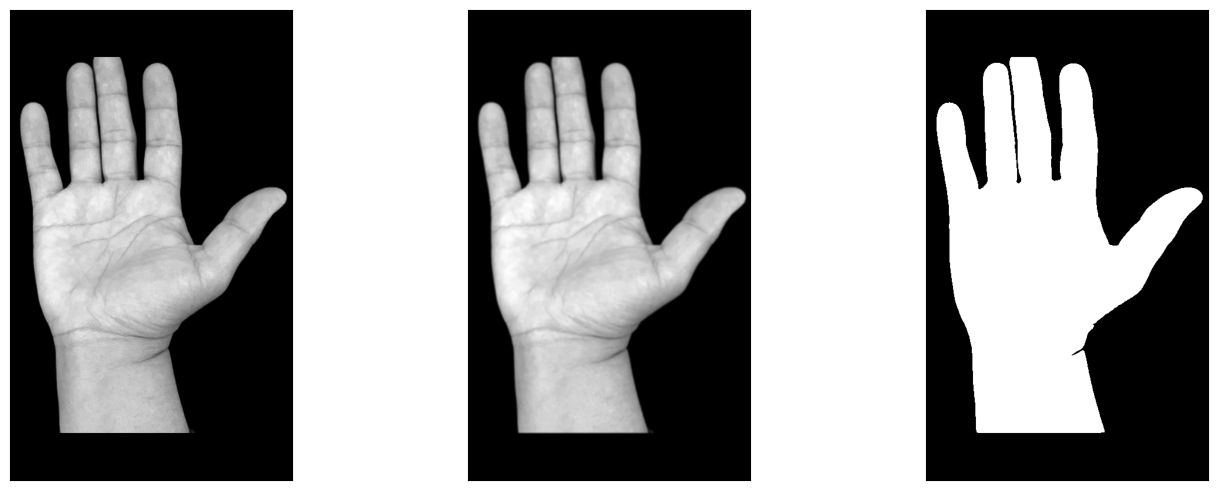

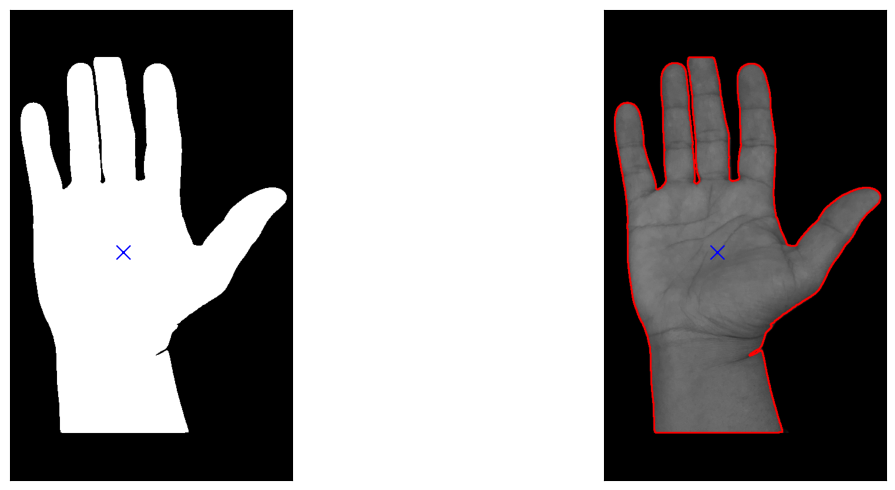

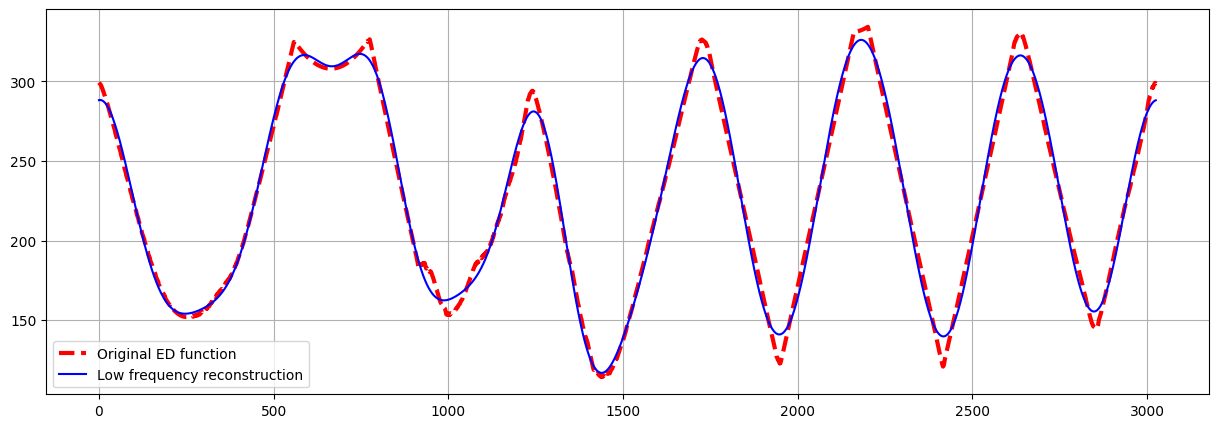

Power Retained: 99.9714%


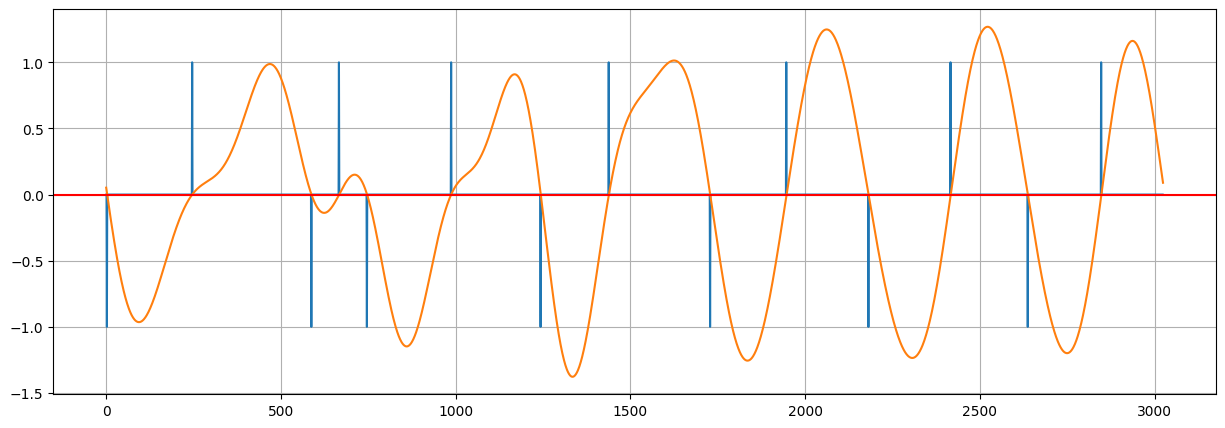

The rotation of ROI is -2.89°


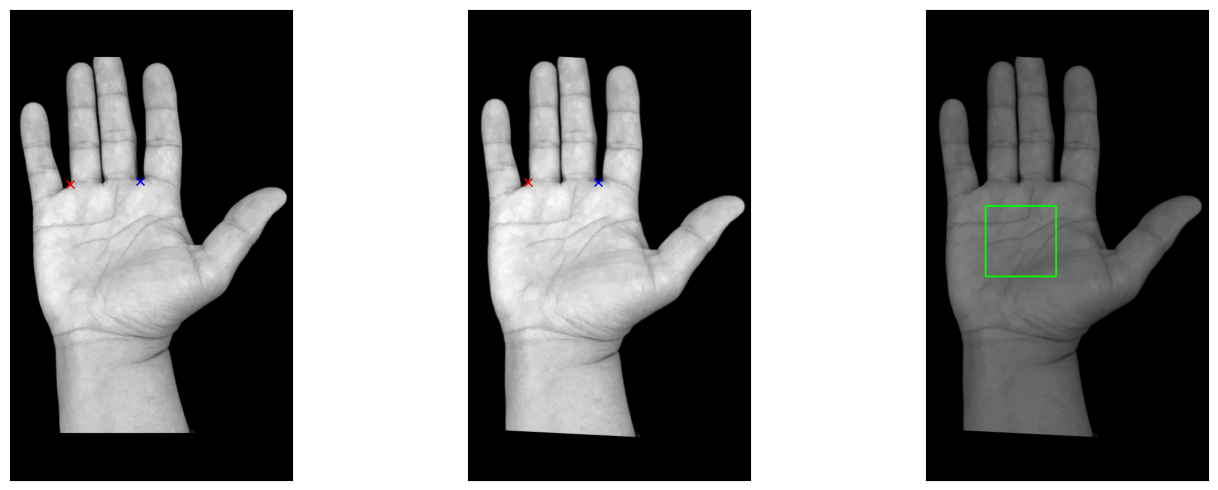

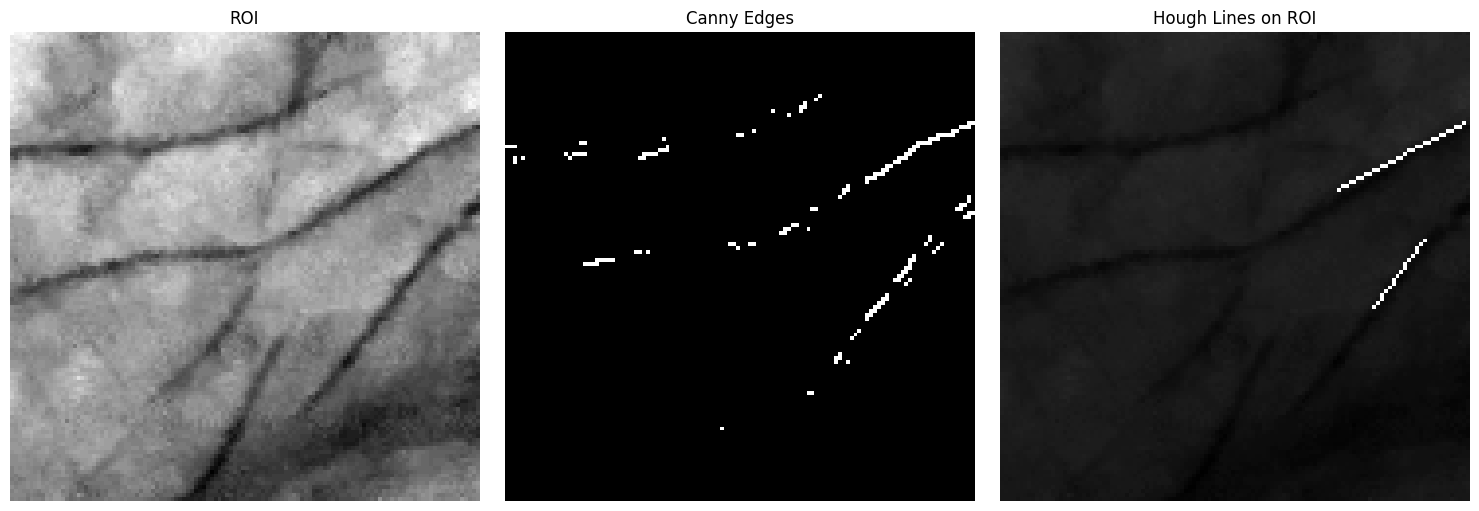

Number of lines detected: 2
Number of edges detected by Canny: 161
Processing image: kk\001\019_F_R_1.JPG


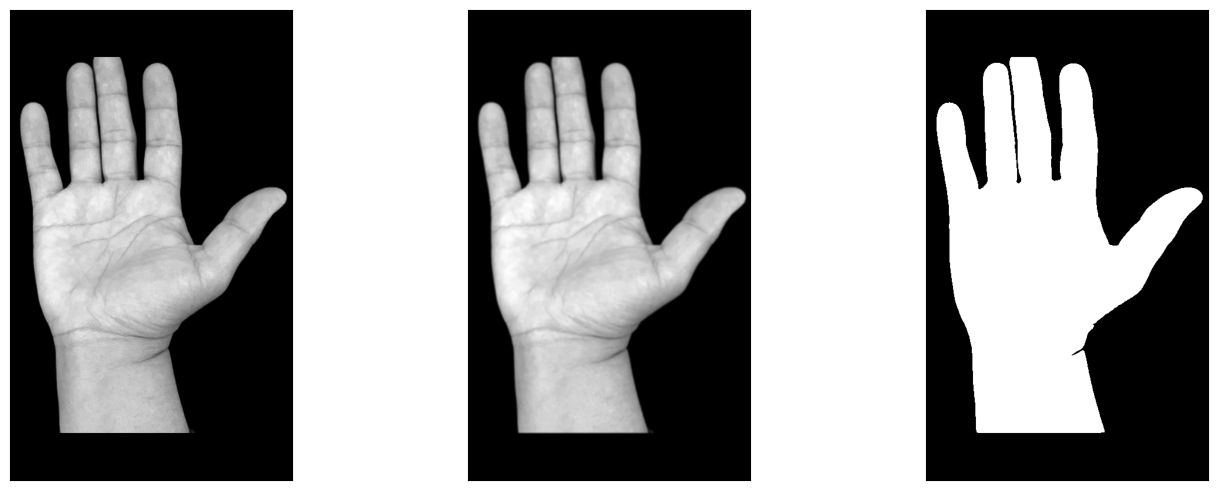

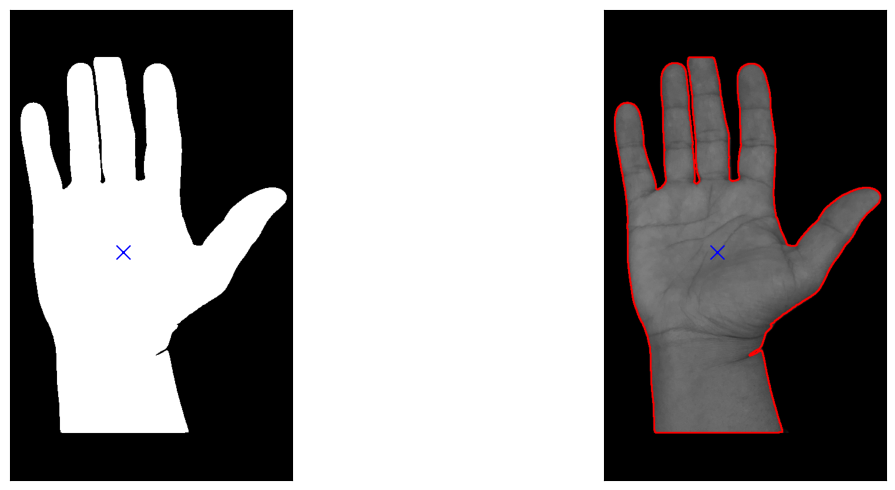

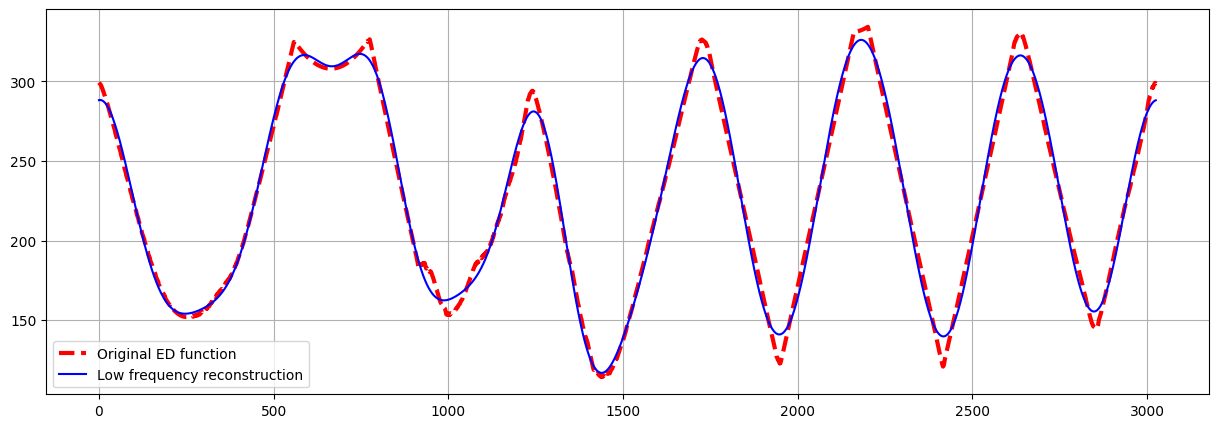

Power Retained: 99.9714%


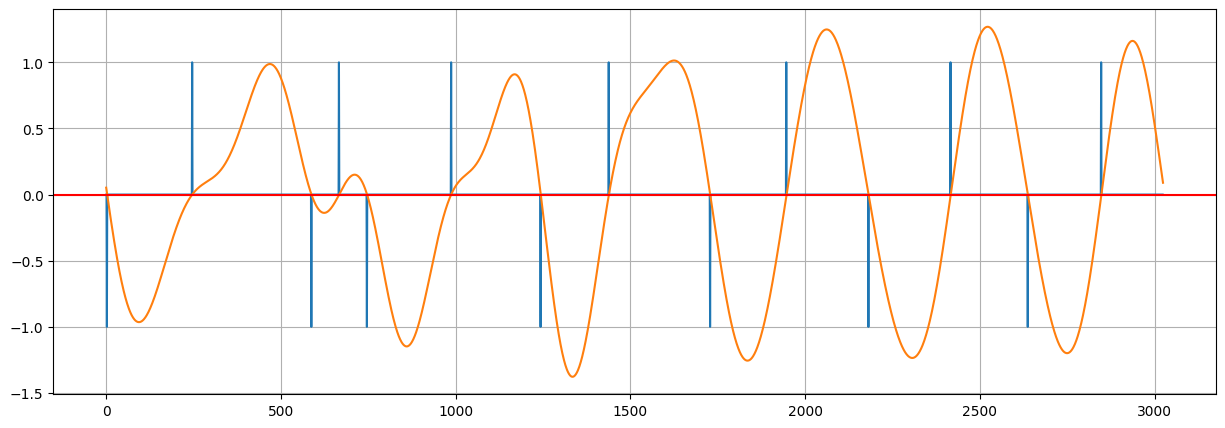

The rotation of ROI is -2.89°


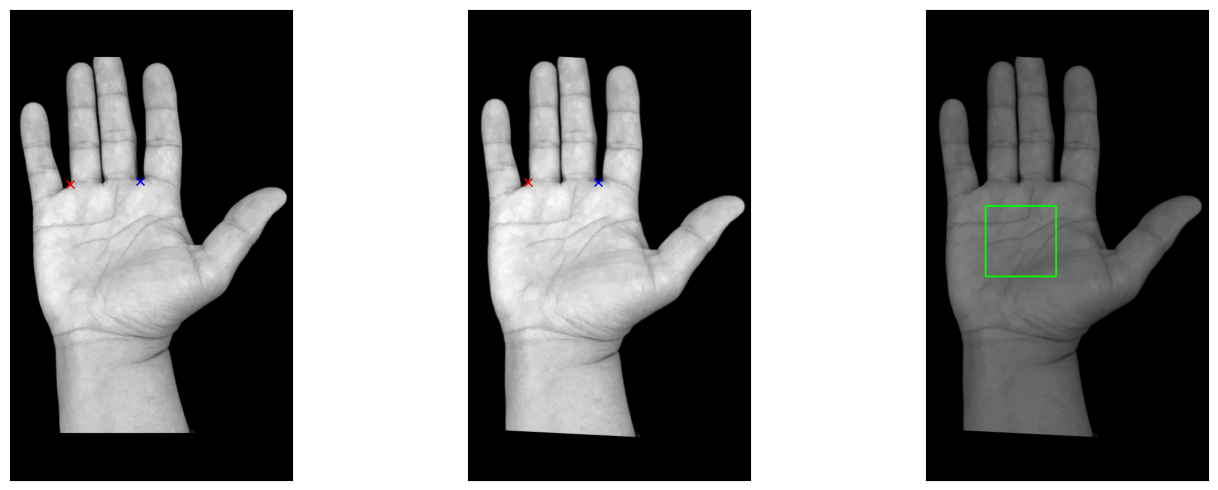

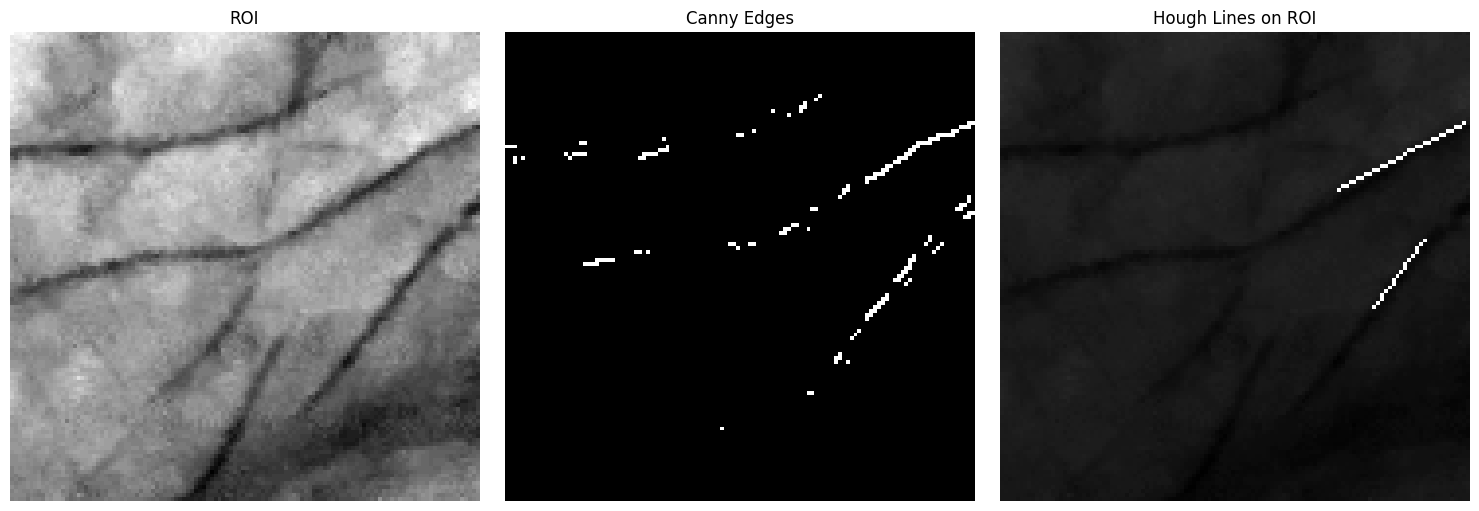

Number of lines detected: 2
Number of edges detected by Canny: 161
Processing image: kk\001\019_F_R_2.JPG


KeyboardInterrupt: 

In [4]:
import os
import csv
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from rembg import remove

def show(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

def process_images_in_folder(parent_folder_path):
    # Create or open a CSV file for writing
    with open('Tangan-Kiri-Canny_semua-perbaikan.csv', mode='w', newline='') as file:
        fieldnames = ['Image Path', 'Label', 'Number of Lines Detected', 'Number of Edges Detected by Canny']
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        # Write the header to the CSV file
        writer.writeheader()

        # Iterate through all folders inside the parent folder
        for folder_name in os.listdir(parent_folder_path):
            folder_path = os.path.join(parent_folder_path, folder_name)
            if os.path.isdir(folder_path):
                print(f"Processing images in folder: {folder_path}")

                # Loop through all files in the folder
                for filename in os.listdir(folder_path):
                    if filename.endswith(".JPG") or filename.endswith(".jpg"):
                        image_path = os.path.join(folder_path, filename)
                        print(f"Processing image: {image_path}")
                        # Extract label from the folder name
                        label = folder_name
                        process_image(image_path, label, writer)

def process_image(image_path, label, writer):
    try:
        # Membaca gambar
        img = cv2.imread(image_path)

        # Periksa apakah gambar berhasil dimuat
        if img is None:
            raise ValueError(f"Gambar tidak dapat dimuat. Pastikan path benar: {image_path}")

        # Mendapatkan lebar dan tinggi gambar
        h, w = img.shape[:2]

        # Mengubah ukuran gambar
        img_resized = cv2.resize(img, dsize=(480, 640), interpolation=cv2.INTER_CUBIC)

        # Mengubah gambar ke grayscale
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Open the input image
        input_image = Image.fromarray(img_resized)

        # Remove the background
        output_image = remove(input_image)

        # Convert the RGBA image (4 channels) to RGB (3 channels) to remove the alpha channel
        if output_image.mode == 'RGBA':
            output_image = output_image.convert("RGB")

        # Convert the PIL image to an OpenCV image
        img_original = np.array(output_image)

        # If the image is not grayscale, convert it to grayscale
        if len(img_original.shape) == 3:
            img_original = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY)

        # Extend the height of the image by 160 pixels (80 on top and 80 on bottom)
        h, w = img_original.shape
        img = np.zeros((h+160, w), np.uint8)
        img[80:-80, :] = img_original

        # Apply Gaussian Blur
        blur = cv2.GaussianBlur(img, (5,5), 0)

        # Apply Otsu's thresholding
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Display the original, blurred, and thresholded images
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        show(img)
        plt.subplot(132)
        show(blur)
        plt.subplot(133)
        show(th)
        plt.tight_layout()
        plt.show()

        M = cv2.moments(th)
        h, w = img.shape
        x_c = M['m10'] // M['m00']
        y_c = M['m01'] // M['m00']
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show(th)
        plt.plot(x_c, y_c, 'bx', markersize=10)
        kernel = np.array([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]]).astype(np.uint8)
        erosion = cv2.erode(th,kernel,iterations=1)
        boundary = th - erosion

        cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cnt = cnt[0]
        img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)
        plt.subplot(122)
        plt.plot(x_c, y_c, 'bx', markersize=10)
        show(img_cnt)
        plt.tight_layout()
        plt.show()

        cnt = cnt.reshape(-1,2)
        left_id = np.argmin(cnt.sum(-1))
        cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])

        dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
        f = np.fft.rfft(dist_c)
        cutoff = 15
        f_new = np.concatenate([f[:cutoff],0*f[cutoff:]])
        dist_c_1 = np.fft.irfft(f_new)
        plt.figure(figsize=(15,5))
        plt.grid()
        plt.plot(dist_c, label='Original ED function', color='r', linewidth='3', linestyle='--')
        plt.plot(dist_c_1, label='Low frequency reconstruction', color='b', linestyle='-')
        plt.legend()
        plt.show()

        eta = np.square(np.abs(f_new)).sum()/np.square(np.abs(f)).sum()
        print('Power Retained: {:.4f}{}'.format(eta*100,'%'))

        derivative = np.diff(dist_c_1)
        sign_change = np.diff(np.sign(derivative))/2
        plt.figure(figsize=(15,5))
        plt.plot(sign_change)
        plt.plot(derivative)
        plt.axhline(y=0, color='r')
        plt.grid()
        plt.show()

        minimas = cnt[np.where(sign_change > 0)[0]]
        v1, v2 = minimas[-1], minimas[-3]
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        show(img)
        plt.plot(v1[0], v1[1],'rx')
        plt.plot(v2[0], v2[1],'bx')

        plt.subplot(132)
        theta = np.arctan2((v2 - v1)[1], (v2 - v1)[0]) * 180/np.pi
        print('The rotation of ROI is {:.02f}\u00b0'.format(theta))
        center = (int((v1[0] + v2[0]) // 2), int((v1[1] + v2[1]) // 2))
        R = cv2.getRotationMatrix2D(tuple(center), theta, 1)
        img_r = cv2.warpAffine(img, R, (w, h))
        v1 = (R[:,:2] @ v1 + R[:,-1]).astype(int)
        v2 = (R[:,:2] @ v2 + R[:,-1]).astype(int)
        plt.plot(v1[0], v1[1],'rx')
        plt.plot(v2[0], v2[1],'bx')
        show(img_r)

        ux = v1[0]
        uy = v1[1] + (v2 - v1)[0] // 3
        lx = v2[0] 
        ly = v2[1] + 4 * (v2 - v1)[0] // 3
        img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(img_c, (lx, ly), (ux, uy), (0, 255, 0), 2)
        plt.subplot(133)
        show(img_c)

        plt.tight_layout()
        plt.show()

        roi = img_r[uy:ly, ux:lx]

        # Assuming 'roi' is the region of interest of your image

        # Given the provided Canny edge detection and Hough line transform parameters, let's apply them and count the number of lines detected.

        # Adjusting the Canny edge detection thresholds as provided
        canny_edges = cv2.Canny(roi, 60, 60)

        # Performing Hough Line Transform with the provided parameters
        lines = cv2.HoughLinesP(canny_edges, 1, np.pi/180, threshold=20, minLineLength=5, maxLineGap=10)

        # Create an image to draw the lines on the ROI
        hough_lines_image = np.zeros_like(roi)

        # Initialize a counter for the number of lines
        number_of_lines = 0
        # Count the number of edges detected by Canny
        num_canny_edges = np.sum(canny_edges > 0)

        # Initialize lists to store line lengths and coordinates
        line_lengths = []
        line_coordinates = []

        # Draw the lines on the image and calculate line lengths and coordinates
        if lines is not None:  # If lines were detected
            number_of_lines = len(lines)
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(hough_lines_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
                # Calculate length of the line
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                line_lengths.append(length)
                # Store coordinates of line endpoints
                line_coordinates.append([(x1, y1), (x2, y2)])

        # Overlay detected lines on the original ROI
        hough_lines_with_roi = cv2.addWeighted(roi, 0.8, hough_lines_image, 1, 0)

        # Display the results
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(roi, cmap='gray')
        plt.title('ROI')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(canny_edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(hough_lines_with_roi, cmap='gray')
        plt.title('Hough Lines on ROI')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f'Number of lines detected: {number_of_lines}')
        print(f'Number of edges detected by Canny: {num_canny_edges}')

        # Write the data to CSV
        writer.writerow({'Image Path': image_path, 'Label': label, 'Number of Lines Detected': number_of_lines, 'Number of Edges Detected by Canny': num_canny_edges})

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Path folder yang berisi gambar-gambar
folder_path = 'Tangan Kiri-1'  # Ganti dengan path folder yang sesuai

# Proses semua gambar di folder tersebut
process_images_in_folder(folder_path)
